In [65]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [66]:
%%time

tweets_df = pd.read_json('../input/iphone-12-tweets-fr.json', lines=True)
tweets_df.head(3)

CPU times: user 2.15 s, sys: 368 ms, total: 2.51 s
Wall time: 6.46 s


,url,date,content,renderedContent,id,user,outlinks,tcooutlinks,replyCount,retweetCount,...,quoteCount,conversationId,lang,source,sourceUrl,sourceLabel,media,retweetedTweet,quotedTweet,mentionedUsers
0,https://twitter.com/jcsatanas/status/135449689...,2021-01-27 18:30:00+00:00,"Ma sélection de coques, étuis, accessoires pou...","Ma sélection de coques, étuis, accessoires pou...",1354496897113706497,"{'username': 'jcsatanas', 'displayname': ' jc...",[https://jcsatanas.fr/ma-selection-de-coques-e...,[https://t.co/XOSSeIbGC4],0,2,...,0,1354496897113706497,fr,"<a href=""https://about.twitter.com/products/tw...",https://about.twitter.com/products/tweetdeck,TweetDeck,[{'previewUrl': 'https://pbs.twimg.com/media/E...,NaN,None,None
1,https://twitter.com/floeuuhh/status/1354495064...,2021-01-27 18:22:43+00:00,@saf_br t’aurai pu avoir l’iPhone 12 avec tout...,@saf_br t’aurai pu avoir l’iPhone 12 avec tout...,1354495064832139266,"{'username': 'floeuuhh', 'displayname': 'flo’ ...",[],[],1,0,...,0,1354465020860653570,fr,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,None,NaN,None,"[{'username': 'saf_br', 'displayname': 'saf’',..."
2,https://twitter.com/eskeke1/status/13544936779...,2021-01-27 18:17:12+00:00,mon père qui vient d'acheter l'iphone 12 et mo...,mon père qui vient d'acheter l'iphone 12 et mo...,1354493677951967232,"{'username': 'eskeke1', 'displayname': 'SauceG...",[],[],0,0,...,0,1354493677951967232,fr,"<a href=""https://mobile.twitter.com"" rel=""nofo...",https://mobile.twitter.com,Twitter Web App,None,NaN,None,None


## 1. Exploration des données

Dans cette étape je vais explorer les tweets, on peut noter que notre source de données dispose plus de 100 mille tweets, ainsi chaque tweets et caractérisé par 21 colomnes.

In [67]:
tweets_df.shape

(62444, 21)

In [68]:
tweets_df.columns

Index(['url', 'date', 'content', 'renderedContent', 'id', 'user', 'outlinks',
       'tcooutlinks', 'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
       'conversationId', 'lang', 'source', 'sourceUrl', 'sourceLabel', 'media',
       'retweetedTweet', 'quotedTweet', 'mentionedUsers'],
      dtype='object')

Ce qui nous interesse le plus c'est la colomne `content` qui contien le contenu du tweet, donc on peux suprimer toute les autres colmnes, à noter que la colmne `renderedContent` est identique à la colomne `content`.

In [69]:
# garder que les colonnes importantes
cols = ['date', 'content', 'lang']
tweets_df = tweets_df[cols]

In [70]:
# pour etre sur que tout les tweets sont en français
tweets_df = tweets_df[tweets_df['lang'] == 'fr']
tweets_df['lang'].unique()

array(['fr'], dtype=object)

Pour vérifier l'évolution des tweets au fil du temps en utilisant la colomne `date`.

In [71]:
# garder que la date et supprimer l'heure
tweets_df['date'] = pd.to_datetime(tweets_df['date']).dt.date

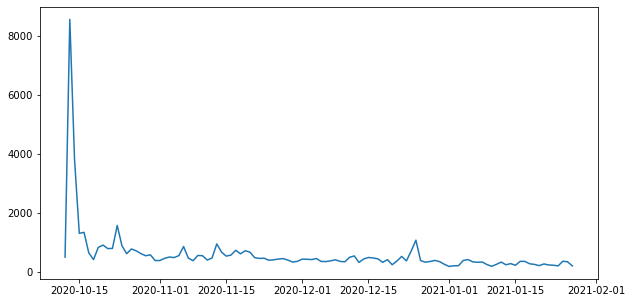

In [72]:
tweets_df['date'].value_counts().plot(kind='line', figsize=(10, 5))

plt.show()

In [73]:
# supprimer les tweets dupliqués, 1K ont été supprimés

tweets_df = tweets_df.sort_values("content") 
  
# dropping ALL duplicte values 
tweets_df = tweets_df.drop_duplicates(subset ="content", keep = 'first')

## 2. Pré-traitement des tweets
Maintenant, après avoir préparé les tweets, nous pouvons commencer la phase de prétraitement afin de pouvoir nettoyer les tweets spécifiquement pour la phase d'identification du sujet. 
Pour des raisons de computation, je ne ferai des expériences que sur une partie des données `(15%)` afin de gagner du temps. Une fois que nous aurons validé le pipeline de prétraitement, je l'appliquerai à l'ensemble des données originales.

In [74]:
# selectionner que les tweets qui répondent au requetes de l'utilisateur

data = tweets_df['content']

keywords = ['stockage', 'écran', 'autonomie', 'réseau', 'alimentation',
           'appareil', 'appareil photo', 'processeur', 'multimédia', 'résolution',
           'batterie', 'système d\'exploitation', 'os', 'pièces', 'couleur',
           'Communication', 'sans fil', 'synchronisation', 'coloris', 'poids',
           'dimensions']

data = data[data.str.contains('|'.join(keywords), case=False)]

In [75]:
ads_words = [
    '#concours', '#jeuconcours', '#giveaway',
    '#gagne' ,'#gangner', '#promo', '#promotion', '#publicité',
    '#contest', '#ad', '#pub', '#réduction']

data = data[~data.str.contains('|'.join(ads_words), case=False)]

### 2.1 Importer les packages
Les paquets de base utilisés dans ce tutoriel sont `re`, `gensim`, `spacy` et `pyLDAvis`. En outre, nous utiliserons également `matplotlib`, `numpy` et `pandas` pour le traitement et la visualisation des données qui sont déja importés. 

pour le model du spacy dédié à la langue française, exectutez cette commande sur votre terminal conda:  
`python -m spacy download fr_core_news_sm`  

pour importer le model: `spacy.load('fr_core_news_sm')`

In [76]:
import re
import spacy
from gensim.utils import tokenize

import json

from io import StringIO
from html.parser import HTMLParser

from collections import Counter 

# pour supprimer les emojis
# ce package est capable de remplacer les emojis avec leur signification en text BEAST!!!
#import demoji
#demoji.download_codes()

In [77]:
# fonction pour supprimer les symbols HTML

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    '''
    input, output: string
    '''
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [78]:
# remplacement des abréviations

with open('../input/abrivot_fr.json', encoding='utf-8') as f:
    abrivot = json.load(f)
    
def replace_abrivot(text):
    '''
    input: string
    output: list of tokens
    '''
    words = text.split()
    text_out = [abrivot[word] if word in abrivot else word for word in words]
    return ' '.join(text_out)

In [79]:
# lemmatization fonction
# supprimer les chiffres, les 

# si ça marche pas
nlp = spacy.load('fr_core_news_sm', disable=['parser', 'ner'])


def lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'ADV']):
    '''
    input: string
    output: list of tokens
    '''
    doc = nlp(text) 
    text_out = [token.lemma_ for token in doc if token.pos_ in allowed_postags and token.is_alpha]
    return text_out

In [80]:
# fonction générale pour le prétraitement

def tweets_preprocesser(tweets):
    all_tweets=[]
    for tweet in tweets:
        
        # supprimer les symboles HTML
        reformed = strip_tags(tweet)
        
        # supprimer les urls et les @mentions
        reformed = re.sub(r'(?:\@|https?\://)\S+', '', reformed)
        
        # remplacer les abréviations
        reformed = replace_abrivot(reformed)
        
        # lemmatization
        tokens = lemmatization(reformed)
        
        #tweet_cleaned = " ".join(tokens)
        #all_tweets.append(tweet_cleaned)
        all_tweets.append(tokens)
    #all_text = ' '.join(all_tweets)
    #all_words = ' '.join(all_tweets)
    return all_tweets#, all_words

In [81]:
%%time

all_tweets = tweets_preprocesser(data)
all_tweets[:1]

CPU times: user 41.3 s, sys: 0 ns, total: 41.3 s
Wall time: 41.3 s


[['désaccord', 'poto', 'votez', 'plus', 'bel', 'couleur', 'iphone', 'max']]

In [82]:
all_text = ' '.join([' '.join(sent) for sent in all_tweets])
all_words = all_text.split()

In [83]:
# préparer la liste des mots vide, 626 mots
# importer les mots vides de la langue Française

stop_words = nlp.Defaults.stop_words

# fonction pour séléctionner les n mots le plus pertinants
# pour les rajouter dans la liste des mots vides

def select_top_words(bag_words, n_words=30):
    
    # Count all the words using Counter Method
    count_words = Counter(all_words)
    total_words=len(all_words)
    sorted_words=count_words.most_common(total_words)
    
    # select the n_words top words
    top_words = [word[0] for word in sorted_words[:n_words]]
    return top_words

# mettre à jour la liste des mots vides avec les 30 mots les plus fréquents
stop_words.update(select_top_words(all_words))

# mettre à jour la liste d'aprés le fichies des mots vides
with open('../input/fr_stopwords.txt', encoding='utf-8') as f:
    fr_stopwords = f.read().splitlines()
stop_words.update(fr_stopwords)

In [84]:
# supprimer les mots vides
def remove_stopwords(texts):
    
    tokens = [[word for word in doc if word not in stop_words] for doc in texts]
    all_tweets = [doc for doc in tokens if len(doc) > 0] # empthy list not allowed
    
    return all_tweets

all_tweets = remove_stopwords(all_tweets)

## Create the Dictionary and Corpus needed for Topic Modeling

In [85]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(all_tweets)

# Create Corpus
texts = all_tweets

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


## Building the Topic Model

In [86]:
import gensim

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## View the topics in LDA model

In [87]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.080*"magsafe" + 0.076*"question" + 0.072*"go" + 0.071*"an" + '
  '0.064*"capacité" + 0.059*"moment" + 0.059*"souci" + 0.053*"mémoire" + '
  '0.051*"air" + 0.041*"keynote"'),
 (1,
  '0.199*"mois" + 0.122*"spécial" + 0.077*"boutique" + 0.074*"vente" + '
  '0.058*"offre" + 0.056*"achat" + 0.043*"coloris" + 0.024*"nouvelle" + '
  '0.018*"détail" + 0.016*"rappel"'),
 (2,
  '0.204*"modèle" + 0.180*"taille" + 0.073*"bientôt" + 0.028*"français" + '
  '0.014*"comparaison" + 0.013*"peur" + 0.010*"innovation" + 0.006*"davantage" '
  '+ 0.006*"classe" + 0.003*"chaud"'),
 (3,
  '0.202*"mise" + 0.136*"heure" + 0.081*"utilisation" + 0.072*"nouveauté" + '
  '0.035*"rapport" + 0.031*"application" + 0.011*"standard" + 0.007*"quasi" + '
  '0.000*"point" + 0.000*"journée"'),
 (4,
  '0.294*"x" + 0.115*"xr" + 0.099*"gamme" + 0.050*"réduction" + '
  '0.040*"silicone" + 0.029*"connexion" + 0.017*"mesure" + 0.000*"code" + '
  '0.000*"réduc" + 0.000*"bureau"'),
 (5,
  '0.116*"ipad" + 0.109*"capteur" +

## Compute Model Perplexity and Coherence Score

In [88]:
from gensim.models import CoherenceModel

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=all_tweets, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -22.901368151639055

Coherence Score:  0.5052380958639244


## Visualize the topics-keywords

In [89]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.349075 -0.113577       1        1  11.188142
7      0.030960  0.029255       2        1   8.370774
9     -0.005962 -0.006260       3        1   7.647454
15     0.011456  0.006924       4        1   7.324967
12     0.087377  0.339043       5        1   7.194441
5     -0.014973 -0.011417       6        1   6.921016
14    -0.015092 -0.011589       7        1   6.179811
1      0.000792 -0.001665       8        1   5.447168
6     -0.031738 -0.018926       9        1   5.375945
19    -0.040779 -0.021261      10        1   4.798578
2     -0.040907 -0.021244      11        1   4.491588
13    -0.021638 -0.014560      12        1   4.238290
3     -0.038366 -0.020735      13        1   3.931102
4     -0.026579 -0.016711      14        1   3.620260
11    -0.042787 -0.020446      15        1   3.403568
8     -0.036115 -0.020153      16        1   3.254614
18    -0.042708 -0.020514      17        1   2.445222
10    -0.041037 -0.018963      18        1   1.929853
16    -0.039666 -0.018022      19        1   1.167943
17    -0.041311 -0.019180      20        1   1.069264, topic_info=            Term        Freq       Total Category  logprob  loglift
268       rapide  851.000000  851.000000  Default  30.0000  30.0000
205       charge  578.000000  578.000000  Default  29.0000  29.0000
166            x  440.000000  440.000000  Default  28.0000  28.0000
189        pouce  538.000000  538.000000  Default  27.0000  27.0000
58          mois  449.000000  449.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
1598      moitié    0.046102    2.114273  Topic20  -9.1640   0.7126
343     stockage    0.046110    2.114747  Topic20  -9.1638   0.7125
122    démontage    0.046103    2.114503  Topic20  -9.1640   0.7125
501   magnifique    0.046101    2.114426  Topic20  -9.1641   0.7125
399      qualité    0.046102    2.114888  Topic20  -9.1640   0.7123

[688 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
299       8  0.986458         achat
4         2  0.933626     actualité
295      17  0.954939  actuellement
174       1  0.993463           air
316      15  0.354672        amazon
...     ...       ...           ...
259       2  0.987543       youtube
66        9  0.918174      écologie
211       4  0.915110     également
212       7  0.884780         élevé
280       1  0.968584     événement

[209 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 8, 10, 16, 13, 6, 15, 2, 7, 20, 3, 14, 4, 5, 12, 9, 19, 11, 17, 18])

## Building LDA Mallet Model

In [94]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '../packages/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [95]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=all_tweets, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(19,
  [('mois', 0.07043701799485862),
   ('super', 0.043701799485861184),
   ('rouge', 0.030848329048843187),
   ('côté', 0.02724935732647815),
   ('code', 0.02519280205655527),
   ('suite', 0.02210796915167095),
   ('succès', 0.018508997429305913),
   ('janvier', 0.018508997429305913),
   ('remise', 0.018508997429305913),
   ('album', 0.017480719794344474)]),
 (12,
  [('incroyable', 0.05217391304347826),
   ('monde', 0.04552429667519182),
   ('journée', 0.03836317135549872),
   ('soir', 0.03580562659846547),
   ('hier', 0.03529411764705882),
   ('capacité', 0.034782608695652174),
   ('stockage', 0.03375959079283888),
   ('keynote', 0.03324808184143223),
   ('demain', 0.028132992327365727),
   ('magnifique', 0.024552429667519183)]),
 (4,
  [('verre', 0.04224652087475149),
   ('pixel', 0.0352882703777336),
   ('niveau', 0.03429423459244533),
   ('cas', 0.031312127236580514),
   ('grosse', 0.0268389662027833),
   ('résistant', 0.024353876739562623),
   ('promo', 0.023359840954274354),


## How to find the optimal number of topics for LDA?

In [96]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [97]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=all_tweets, start=2, limit=40, step=6)

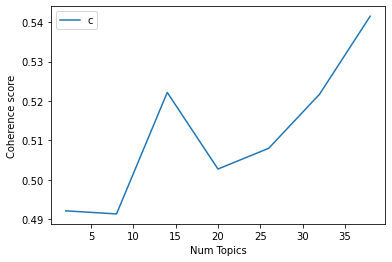

In [98]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [99]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4922
Num Topics = 8  has Coherence Value of 0.4914
Num Topics = 14  has Coherence Value of 0.5222
Num Topics = 20  has Coherence Value of 0.5028
Num Topics = 26  has Coherence Value of 0.508
Num Topics = 32  has Coherence Value of 0.5217
Num Topics = 38  has Coherence Value of 0.5415


In [100]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.051*"main" + 0.035*"site" + 0.035*"jamais" + 0.030*"demain" + '
  '0.027*"vite" + 0.024*"commande" + 0.024*"livraison" + 0.022*"bonjour" + '
  '0.021*"boîte" + 0.020*"choix"'),
 (1,
  '0.034*"temps" + 0.032*"vie" + 0.031*"verre" + 0.027*"part" + 0.027*"mort" + '
  '0.023*"compte" + 0.020*"fille" + 0.020*"mec" + 0.017*"grave" + '
  '0.017*"résistant"'),
 (2,
  '0.068*"disponible" + 0.058*"modèle" + 0.034*"précommande" + 0.027*"point" + '
  '0.027*"journée" + 0.026*"capacité" + 0.026*"soir" + 0.025*"hier" + '
  '0.024*"stockage" + 0.023*"octobre"'),
 (3,
  '0.042*"oui" + 0.040*"monde" + 0.035*"moment" + 0.031*"mieux" + '
  '0.024*"client" + 0.023*"utilisateur" + 0.020*"gars" + 0.017*"truc" + '
  '0.017*"gosse" + 0.016*"mère"'),
 (4,
  '0.065*"apple" + 0.047*"mise" + 0.044*"igeneration" + 0.041*"mal" + '
  '0.029*"argent" + 0.025*"bug" + 0.020*"magnétique" + 0.014*"choisir" + '
  '0.014*"message" + 0.014*"système"'),
 (5,
  '0.062*"réseau" + 0.050*"taille" + 0.043*"compatible" +